In [1]:
import data

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = data.get_course_data()

100%|███████████████████████████████████████████| 12/12 [07:34<00:00, 37.88s/it]


In [16]:
# !pip install -U segmentation-models-pytorch albumentations --user
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision.models.segmentation
from torchvision.transforms import ToTensor, ToPILImage
from torch.utils.data import Dataset, DataLoader
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

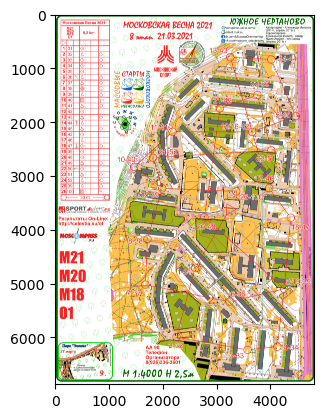

In [6]:
plt.imshow(data.draft.X[7])


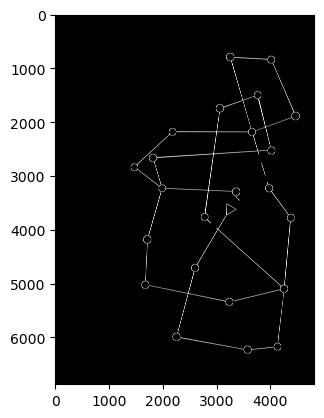

In [7]:
plt.imshow(data.draft.y[7], cmap='gray')

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-12-15 04:46:56.765997: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-15 04:46:57.078704: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 04:46:57.078764: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 04:46:57.133016: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 04:46:57.249051: I tensorflow/core/platform/cpu_feature_guar

In [9]:
def downsample_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(x)
    f = layers.Conv2D(n_filters, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(x)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

In [10]:
def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(x)
    return x

In [11]:
# https://stackoverflow.com/a/49290815
def jaccard_distance(y_true, y_pred, smooth=100):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) * smooth
    return tf.reduce_mean(jd)

In [12]:
inputs = layers.Input(shape=(128,128,3))
f1, p1 = downsample_block(inputs, 16)
f2, p2 = downsample_block(p1, 32)
x = layers.Conv2D(64, 3, padding = "same", activation = "elu", kernel_initializer = "he_normal")(p2)
x = layers.Dropout(0.3)(x)
u2 = upsample_block(x, f2, 32)
u1 = upsample_block(u2, f1, 16)
outputs = layers.Conv2D(1, 3, padding = "same", activation = "sigmoid", kernel_initializer = "he_normal")(u1)
unet_model = tf.keras.Model(inputs, outputs, name="U-Net")


2023-12-15 04:47:40.382105: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [13]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=["accuracy", jaccard_distance])

In [14]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, draft_data, sz, batch_size=16, dim=(128,128), n_channels=3,
                 shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.draft = draft_data
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.len = sz
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(self.len / self.batch_size)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.len)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            elem = self.draft[ID]
            # Store sample
            X[i,] = elem[0]

            # Store class
            y[i] = elem[1]

        return X, y

In [18]:
train = DataGenerator(data, 5000)
val = DataGenerator(data, 64)
# del data

In [19]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.TensorBoard()
]

In [20]:
model_history = unet_model.fit(train,
                               verbose=2,
                               epochs=10,
                               validation_data=val                                )

Epoch 1/10
312/312 - 58s - loss: 0.0428 - accuracy: 0.9867 - jaccard_distance: 46.8744 - val_loss: 0.0268 - val_accuracy: 0.9921 - val_jaccard_distance: 34.7864 - 58s/epoch - 185ms/step
Epoch 2/10
312/312 - 57s - loss: 0.0292 - accuracy: 0.9900 - jaccard_distance: 37.2980 - val_loss: 0.0248 - val_accuracy: 0.9936 - val_jaccard_distance: 22.4034 - 57s/epoch - 182ms/step
Epoch 3/10
312/312 - 58s - loss: 0.0230 - accuracy: 0.9921 - jaccard_distance: 30.9702 - val_loss: 0.0107 - val_accuracy: 0.9957 - val_jaccard_distance: 26.3651 - 58s/epoch - 187ms/step
Epoch 4/10
312/312 - 57s - loss: 0.0253 - accuracy: 0.9914 - jaccard_distance: 31.8641 - val_loss: 0.0169 - val_accuracy: 0.9948 - val_jaccard_distance: 33.4106 - 57s/epoch - 183ms/step
Epoch 5/10
312/312 - 58s - loss: 0.0196 - accuracy: 0.9935 - jaccard_distance: 25.8265 - val_loss: 0.0225 - val_accuracy: 0.9913 - val_jaccard_distance: 23.4146 - 58s/epoch - 185ms/step
Epoch 6/10
312/312 - 58s - loss: 0.0190 - accuracy: 0.9936 - jaccard_d

In [24]:
fig = plt.figure(figsize=(100, 100))
for i in range(5):
    X, y = val[0]#     X = X.permute(1, 2, 0).numpy()
    X = X[i]
    y = y[i]
    print(X.shape)
    print(y.shape)
    pred = unet_model.predict(np.array([X]))
    fig.add_subplot(5, 3, 3 * i + 1)
    plt.imshow(X)
    fig.add_subplot(5, 3, 3 * i + 2)
    plt.imshow(y * 255, cmap='gray')
    fig.add_subplot(5, 3, 3 * i + 3)
    plt.imshow(pred[0], cmap='gray')
plt.show()

(128, 128, 3)
(128, 128)
1/1 [==============================] - 0s 20ms/step
(128, 128, 3)
(128, 128)
1/1 [==============================] - 0s 20ms/step
(128, 128, 3)
(128, 128)
1/1 [==============================] - 0s 20ms/step
(128, 128, 3)
(128, 128)
1/1 [==============================] - 0s 20ms/step
(128, 128, 3)
(128, 128)
1/1 [==============================] - 0s 20ms/step


In [25]:
unet_model.save_weights('./checkpoints/unet_course')

In [37]:
img = cv2.imread('data/карта 1_1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
res = np.zeros((img.shape[0], img.shape[1], 1), dtype=np.float64)
for i in range(0, img.shape[0], 128):
    for j in range(0, img.shape[1], 128):
        if i + 128 > img.shape[0]:
            i = img.shape[0] - 128
        if j + 128 > img.shape[1]:
            j = img.shape[1] - 128
        res[i:i+128,j:j+128] = unet_model.predict(np.float64(img[i:i+128,j:j+128]).reshape(-1, 128, 128, 3) / 255)[0]
res = cv2.blur(res, (5,5))


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


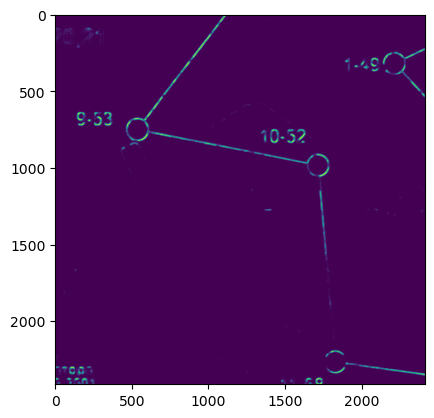

In [38]:
plt.imshow(res)